### Augment tasmin from NEX-GDDP-CMIP6 for existing orchards using xclim.

# References:
- https://www.almanac.com/gardening/frostdates#:~:text=Frost%20is%20predicted%20when%20air,exposes%20surfaces%20to%20radiative%20cooling.


In [6]:
import xclim
import sys 
import os
import s3fs

rel_path = "../src"
directory_path = os.path.abspath(os.path.join(os.getcwd(), rel_path))
sys.path.append(directory_path)

from nex_gddp_cmip6 import get_nex_dataset, TIME_OPTIMIZED_SCENARIOS, AVAILABLE_VARIABLES, load_region, select_region

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import dask
from dask.distributed import Client

# https://dask.pydata.org/en/latest/diagnostics-local.html
from dask.distributed import Client, progress
from dask.diagnostics import ProgressBar

In [11]:
# Initiate Dask Cluster

endpoint = ""

if endpoint:
    client = Client(endpoint)

else:
    client = Client()

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59980,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.92 GiB
Comm: tcp://127.0.0.1:60005,Total threads: 3
Dashboard: http://127.0.0.1:60011/status,Memory: 7.98 GiB
Nanny: tcp://127.0.0.1:59983,


In [ ]:
# when ready to shutdown cluster
#client.shutdown()

In [9]:
# Load Data

ds_historical = get_nex_dataset(AVAILABLE_VARIABLES,["historical"])

geodf = load_region('../assets/data/external/MI_avas.geojson')
ds_historical_clipped = select_region(ds_historical, geodf)

In context, 0c is frost date for Michigan. 

- https://www.almanac.com/gardening/frostdates/MI/Detroit#:~:text=Frost%20is%20predicted%20when%20air,exposes%20surfaces%20to%20radiative%20cooling.
- https://www.canr.msu.edu/resources/frost-free-dates

In [10]:
# using one climate model, between a very short time range of 10 years
da = ds_historical_clipped['tasmin'].sel(model = 'ACCESS-CM2', time=slice('1950-01-01T12:00:00.000000000', '1960-12-31T12:00:00.000000000'))

In [12]:
da

<xarray.DataArray 'tasmin' (scenario: 1, time: 4018, lat: 16, lon: 14)> Size: 4MB
dask.array<getitem, shape=(1, 4018, 16, 14), dtype=float32, chunksize=(1, 4018, 13, 12), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 128B 41.88 42.12 42.38 ... 45.12 45.38 45.62
  * lon          (lon) float64 112B 93.38 93.62 93.88 ... 96.12 96.38 96.62
    model        <U10 40B 'ACCESS-CM2'
  * scenario     (scenario) <U10 40B 'historical'
  * time         (time) datetime64[ns] 32kB 1950-01-01T12:00:00 ... 1960-12-3...
    spatial_ref  int32 4B 0
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: minimum
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    long_name:      Daily Minimum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

frost free season start (default parameters)

Notes:
1. since a data array is passed, dask is running the hood.
2. degree Celcius converted into Kelvin scale is 273.15 K
2. frost_free_season_start returns 'Day of the year of the beginning of the frost-free season, defined as the {window}th consecutive day when minimum daily temperature exceeds {thresh}'

In [43]:
# https://docs.dask.org/en/stable/diagnostics-distributed.html
# https://xclim.readthedocs.io/en/stable/_modules/xclim/core/units.html

# takes about 10-15 minutes
ffss_da = xclim.indicators.atmos.frost_free_season_start(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [65]:
# 20 - 25 minutes
ffse_da = xclim.indicators.atmos.frost_free_season_end(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [67]:
# fast 1-2 seconds
ffsl_da = xclim.indicators.atmos.frost_free_season_length(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [68]:
# < 1 second
frost_days_da = xclim.indicators.atmos.frost_days(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [71]:
last_spring_frost_da = xclim.indicators.atmos.last_spring_frost(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 
late_frost_days_da = xclim.indicators.atmos.late_frost_days(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [72]:
consecutive_frost_days_da = xclim.indicators.atmos.consecutive_frost_days(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [77]:
# window:  The length of the averaging window, in years.
 
#usda_hardiness_zones_da = xclim.indicators.atmos.usda_hardiness_zones(tasmin = da, ds = ds_historical_clipped, window = 5) 

In [53]:
ffss_da 

<xarray.DataArray 'frost_free_season_start' (scenario: 1, time: 11, lat: 16,
                                             lon: 14)> Size: 20kB
dask.array<where, shape=(1, 11, 16, 14), dtype=float64, chunksize=(1, 1, 13, 12), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 112B 93.38 93.62 93.88 ... 96.12 96.38 96.62
    model        <U10 40B 'ACCESS-CM2'
    spatial_ref  int32 4B 0
  * scenario     (scenario) <U10 40B 'historical'
  * lat          (lat) float64 128B 41.88 42.12 42.38 ... 45.12 45.38 45.62
  * time         (time) datetime64[ns] 88B 1950-01-01 1951-01-01 ... 1960-01-01
Attributes:
    units:          
    is_dayofyear:   1
    calendar:       default
    cell_methods:   area: mean time: minimum
    history:        [2024-03-14 18:34:09] frost_free_season_start: FROST_FREE...
    standard_name:  day_of_year
    long_name:      First day following a period of 5 days with minimum daily...
    description:    Day of the year of the beginning of the frost-free season...

In [78]:
# 1 scenario, 1 time step,
# takes about 2 minutes

#pbar = ProgressBar()
#pbar.register()

operation = ffss_da[0,0].data
ffse_da_t_0 = ffse_da[0,0].data

In [80]:
#frost_free_season_end = ffse_da_t_0.compute()

In [47]:
out = operation.compute()

In [54]:
ffss_da[0,0].data

dask.array<getitem, shape=(16, 14), dtype=float64, chunksize=(13, 12), chunktype=numpy.ndarray>

In [56]:
out.shape

(16, 14)

In [61]:
ffss_da_year_0 = ffss_da.isel(time = 0)

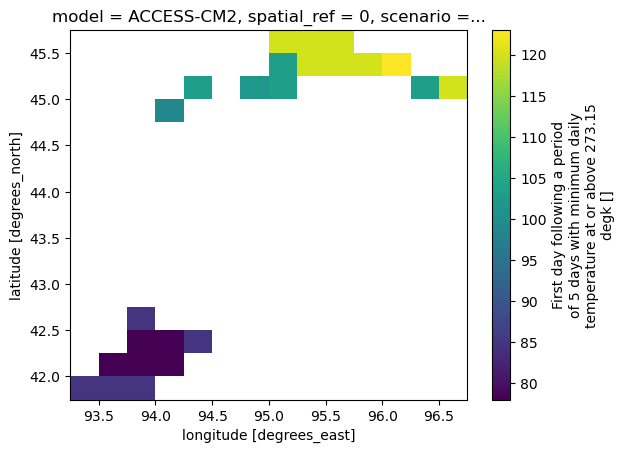

In [63]:
# takes about 2 minutes

# for 1950
ffss_da_year_0.plot()

In [64]:
#ffss_df = ffss_da.to_dask_dataframe(['scenario','time','lat','lon'])

In [ ]:
ffss_df 